In [1]:
%load_ext autoreload
%autoreload 2

import json
import pyhf
pyhf.set_backend('jax')

import pymc as pm
import arviz as az

import numpy as np

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

# import aesara
import aesara.tensor as at
# from aesara.graph.op import Op
from aesara.link.jax.dispatch import jax_funcify

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp


# import sys
# sys.path.insert(1, '/Users/malinhorstmann/Documents/pyhf_pymc/src')
import MH_inference
import HMC_inference
import prepare_inference

import matplotlib.pyplot as plt

### Model

In [20]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 3],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 55],
     'modifiers': [
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [2.0, 2.0, 2.4],},
        ## Lumi / Normal
        {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [65, 65, 66], 'lo_data': [40, 40, 40]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [66, 65, 60], 'lo_data': [40, 40, 39]}},
        ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 8, 6.7]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7.27, 9, 7]},
        
         ]},    
                                 
    ]},
    ],
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }
        ],}
)

obs = model.expected_actualdata(model.config.suggested_init())

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

In [2]:
with open('SRee_SRmm_Srem.json') as serialized:
# with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

obs = workspace.data(model, include_auxdata=False)

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

In [21]:
# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[1], [0.1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=1, priors=prior_dict)

## HMC

### General Stuff

In [22]:
@jax.jit
def processed_expData(parameters):
    a = jnp.stack([model.expected_actualdata(parameters)[i] for i in range(nBins)])
    return a

one_vector = np.full(nBins, 1., dtype='float64')

@jax.jit
def vjp_expData(parameters):
    _,back = jax.vjp(processed_expData, parameters)
    return back(one_vector)

### Gradient Op

In [23]:
class VJPOp(Op):

    def make_node(self, vjp_func, parameters):
        self.vjp_func = vjp_expData
        inputs = [pt.as_tensor_variable(parameters)]
        outputs = [pt.vector()]
        
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (parameters,) = inputs
        results = vjp_expData(parameters)

        if not isinstance(results, (list, tuple)):
                results = (results,)
                
        for i, r in enumerate(results):
            outputs[i][0] = np.asarray(r)

vjp_op = VJPOp()

### Non-Gradient Op (with `grad` method)

In [24]:
class ExpDataOp(Op):
    
    def make_node(self, func, parameters):
        self.func = processed_expData
        inputs = [pt.as_tensor_variable(parameters)]
        outputs = [pt.vector()]

        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (parameters, ) = inputs
        results = processed_expData(parameters)

        if len(outputs) == 1:
                outputs[0][0] = np.asarray(results)
                return
        for i, r in enumerate(results):
                outputs[i][0] = np.asarray(r)

    def grad(self, vjp_func, parameters):
        return [vjp_op(vjp_func, parameters)]
        
expData_op = ExpDataOp()

### Sampling

In [31]:
with pm.Model():
    pars = prepare_inference.priors2pymc(prepared_model)
    expData_op = ExpDataOp()
    ExpData = pm.Normal("ExpData", mu=expData_op(processed_expData, pars).eval(), sigma=1, observed=obs)
    
    post_data = pm.sample(500)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(500)

print(model.expected_actualdata(model.config.suggested_init()))
az.summary(post_pred, var_names="ExpData")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Unconstrained, Normals, Gammas]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Sampling: [ExpData, Gammas, Normals, Unconstrained]


[61. 61. 58.]


/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ExpData[0],66.935,0.984,65.018,68.712,0.022,0.015,2091.0,1971.0,1.0
ExpData[1],62.630,0.981,60.776,64.420,0.022,0.016,1928.0,2040.0,1.0
ExpData[2],70.254,1.000,68.447,72.132,0.023,0.017,1831.0,1965.0,1.0


## Metropolis-Hasting

In [26]:
MetrHast_post_data, MetrHast_post_pred, MetrHast_prior_pred = MH_inference.sampling(prepared_model, 500)

print(model.expected_actualdata(model.config.suggested_init()))
az.summary(MetrHast_post_pred, var_names="ExpData")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
>Metropolis: [Gammas]
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
>Metropolis: [Gammas]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Sampling: [ExpData, Gammas, Normals, Unconstrained]


[61. 61. 58.]


/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ExpData[0],61.128,1.478,58.497,64.018,0.076,0.054,380.0,810.0,1.03
ExpData[1],60.994,1.492,58.284,63.917,0.068,0.048,481.0,1079.0,1.01
ExpData[2],57.850,1.426,55.265,60.589,0.130,0.092,120.0,990.0,1.04


## Plotting

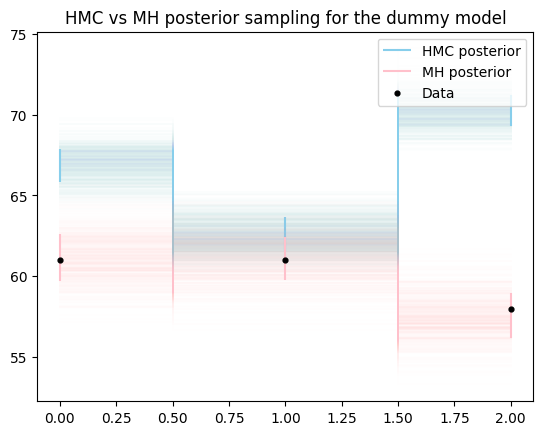

In [32]:
# plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label='HMC prior');

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'skyblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'skyblue', label='HMC posterior')

plt.step(np.linspace(0,nBins-1,nBins),MetrHast_post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'pink', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(MetrHast_post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'pink', label='MH posterior')

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "Data")
plt.legend(loc='upper right')

plt.title(f'HMC vs MH posterior sampling for the dummy model')
# plt.title(f'HMC vs MH posterior sampling for ttbar')

plt.savefig(f'HMC_MH_dummy')
# plt.savefig(f'HMC_MH_ttbar')
plt.show()

/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (68) in plot_autocorr, generating only 40 plots
  warnings.warn(
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (68) in plot_autocorr, generating only 40 plots
  warnings.warn(


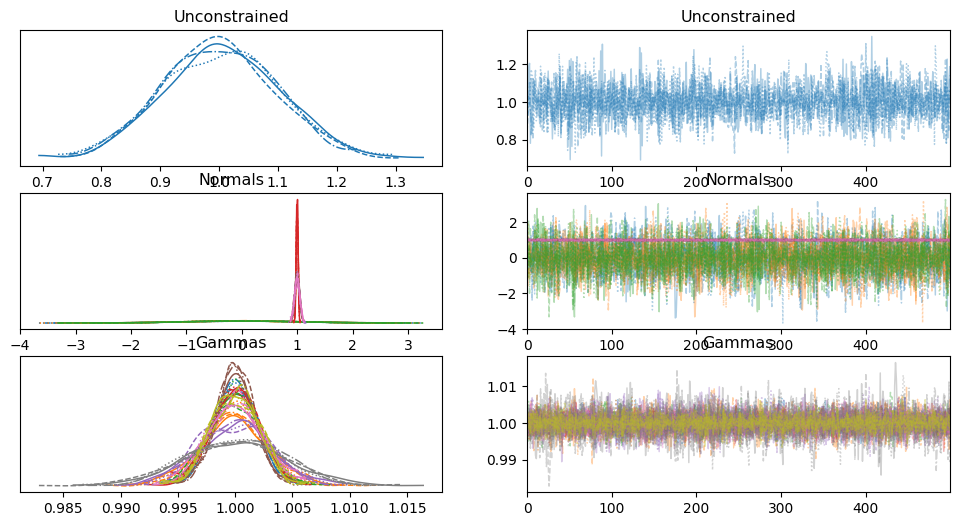

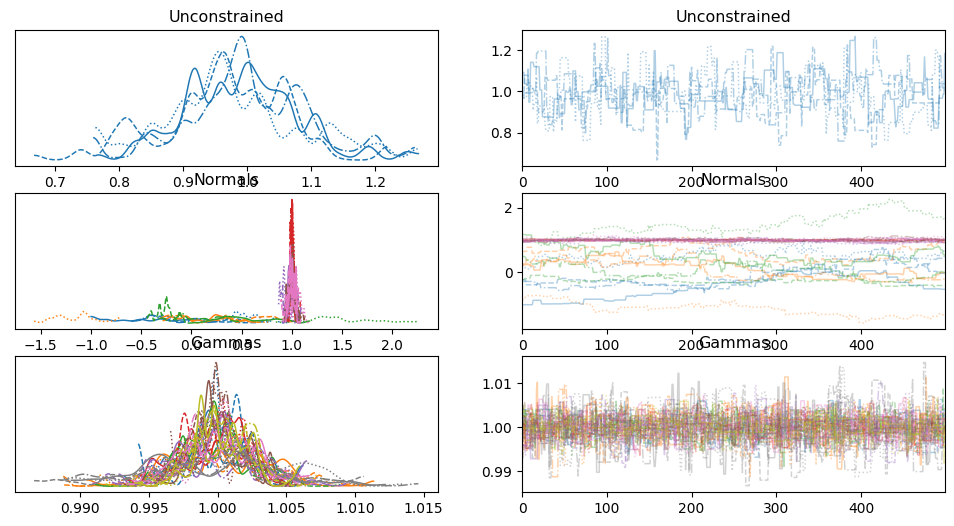

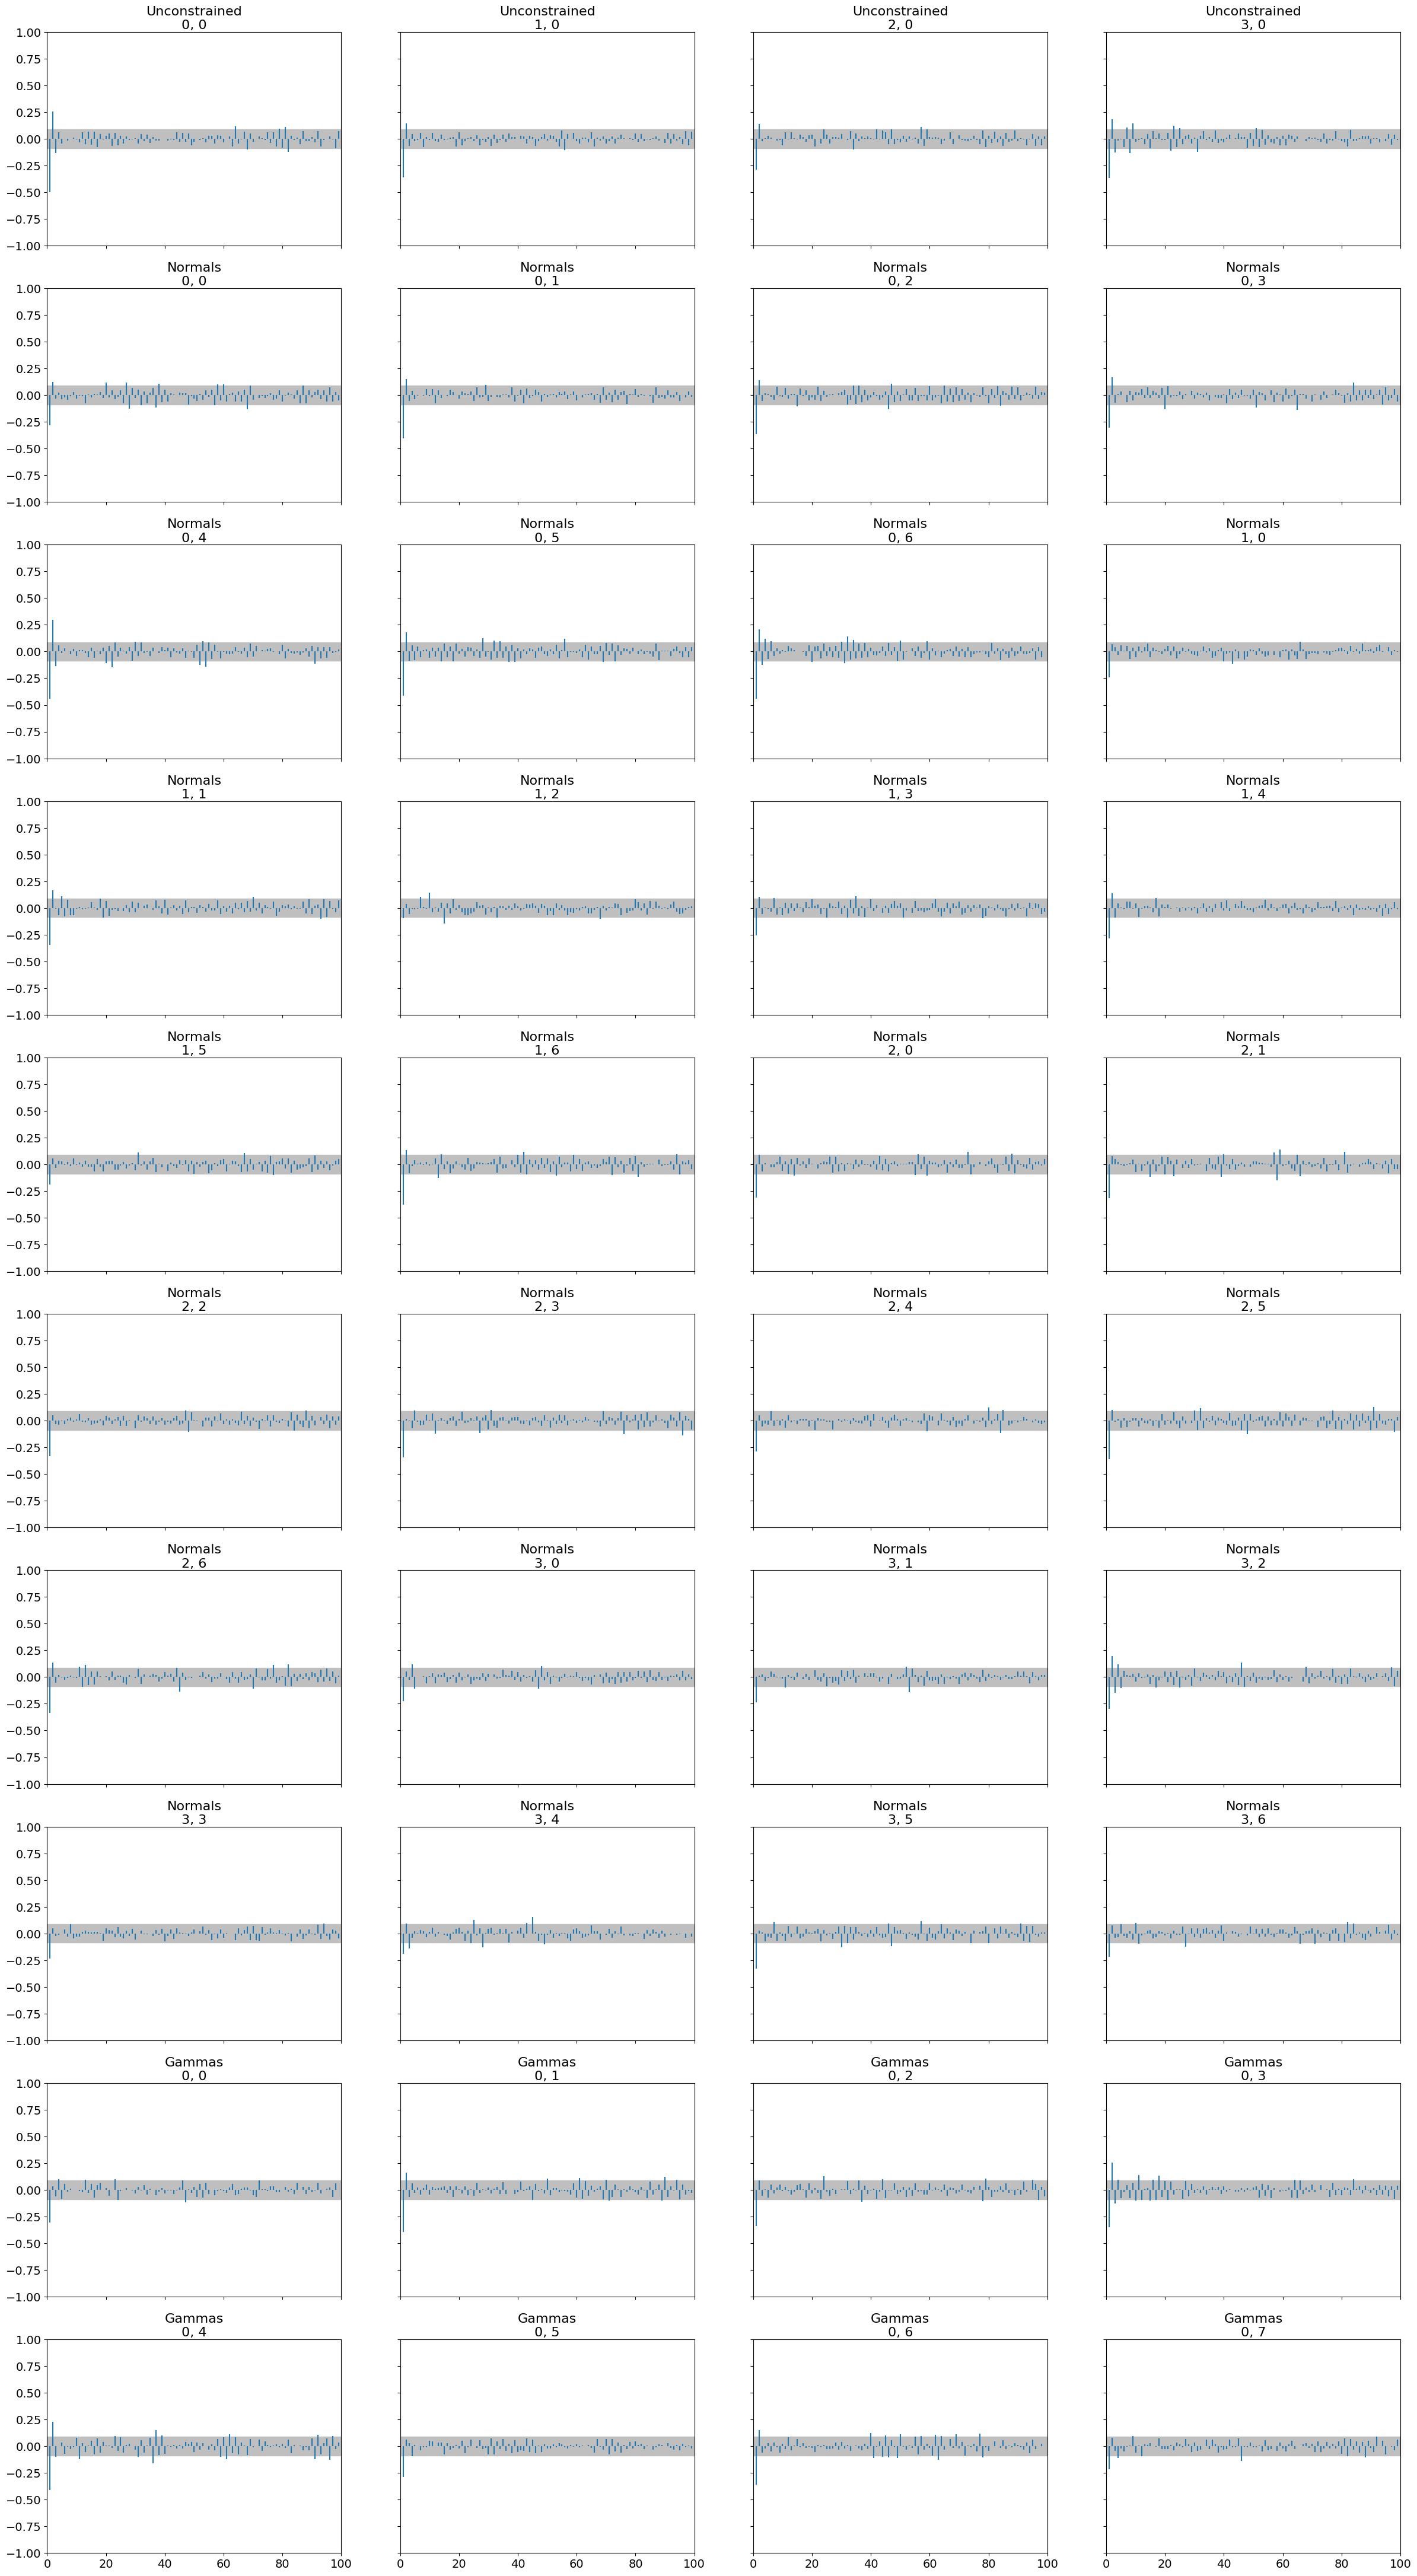

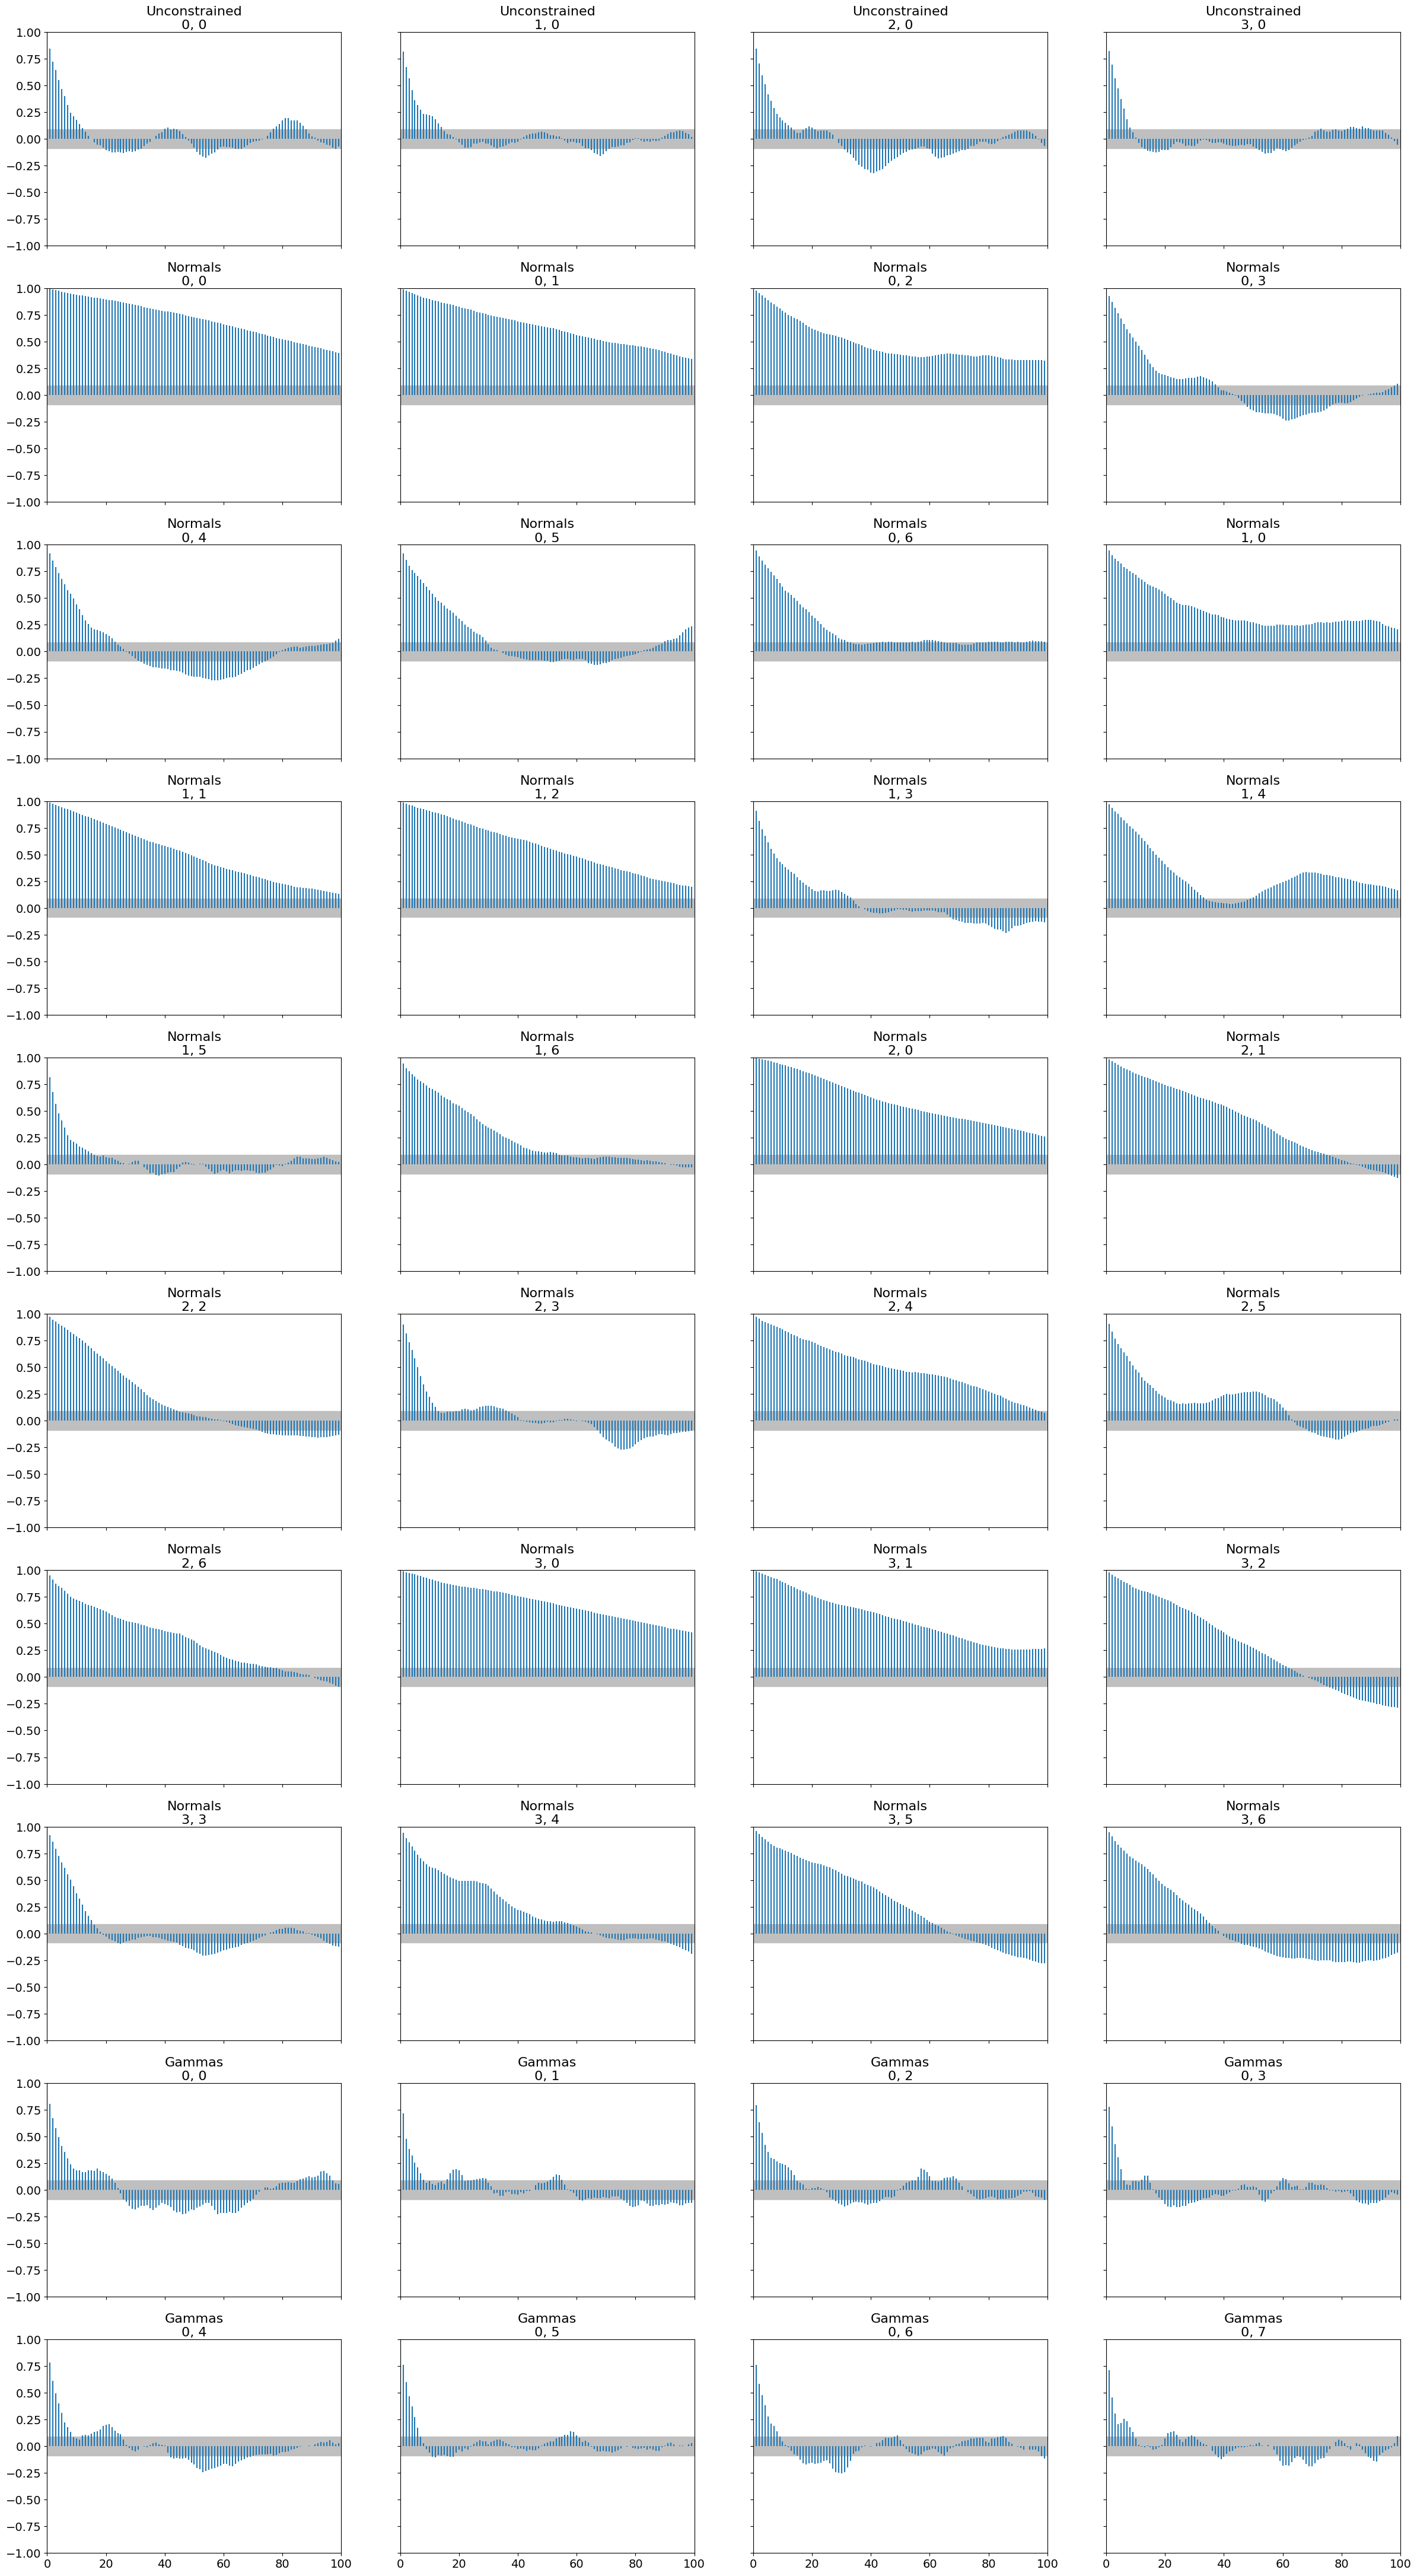

In [33]:
# az.plot_trace(post_data)
# plt.savefig("HMC_traces_DisplacedLeptons")
# az.plot_trace(MetrHast_post_data)
# plt.savefig("MH_traces_DisplacedLeptons")

# az.plot_autocorr(post_data)
# plt.savefig("HMC_autocorr_DisplacedLeptons")
# az.plot_autocorr(MetrHast_post_data)
# plt.savefig("MH_autocorr_DisplacedLeptons")

az.plot_trace(post_data)
plt.savefig("HMC_traces_dummy")
az.plot_trace(MetrHast_post_data)
plt.savefig("MH_traces_dummyr")

az.plot_autocorr(post_data)
plt.savefig("HMC_autocorr_dummy")
az.plot_autocorr(MetrHast_post_data)
plt.savefig("MH_autocorr_dummy")